In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import AgglomerativeClustering
import matplotlib.cm as cm
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/2023_Data_Mining_Physics_vs_Chemistry_vs_Biology_Dataset/klasterovanje

/content/drive/MyDrive/Colab Notebooks/2023_Data_Mining_Physics_vs_Chemistry_vs_Biology_Dataset/klasterovanje


In [4]:
def plot_variance(explained_ratio):
  cum_sum_eigenvalues = np.cumsum(explained_ratio)

  step = 100
  indices = np.arange(0, len(explained_ratio), step)
  indices = np.append(indices, len(explained_ratio) - 1)
  x_ticks = indices[::2]
  y_values = cum_sum_eigenvalues[indices[::2]]

  plt.figure(figsize=(5, 5))
  plt.plot(x_ticks, y_values, marker='o', linestyle='-')
  plt.ylabel('Cumulative explained variance')
  plt.xlabel('Component index')
  plt.title('Cumulative Explained Variance for Every 200th Component')
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [5]:
def plot_dendograms(l1, l2, threshold1, threshold2):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))

  dendrogram(l1, ax=ax1, orientation = 'left', truncate_mode='lastp', p=20, color_threshold=threshold1)
  ax1.set_xlabel('Distance')
  ax1.set_ylabel('Data points')
  ax1.set_title('original')

  dendrogram(l2, ax=ax2, orientation = 'left', truncate_mode='lastp', p=20, color_threshold=threshold2)
  ax2.set_xlabel('Distance')
  ax2.set_ylabel('Data points')
  ax2.set_title('cosine')

  plt.subplots_adjust(wspace=0.6)
  plt.show()

In [6]:
def plot_lsa(lsa_matrix, lsa_matrix_3, labels):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

  ax1.scatter(lsa_matrix[:, 0], lsa_matrix[:, 1], c=labels)

  ax2 = fig.add_subplot(122, projection='3d')
  ax2.scatter(lsa_matrix_3[:, 0], lsa_matrix_3[:, 1], lsa_matrix_3[:, 2], c=labels)
  ax2.grid(True)

  ax2.set_box_aspect([0.6, 0.6, 0.6])
  plt.tight_layout()
  plt.show()

In [7]:
data = pd.read_csv('../pretprocesiranje/cluster_data.csv')

#**Hierarchical**

curse of dimensionality, algoritmi n^3 veoma memorijski i vremenski zahtevni, tako da vrsimo redukciju dimenzija

# pca & lsa

In [8]:
X = data.copy()

In [9]:
pca = PCA(n_components=4000)
pca.fit(X)
X_pca = pca.transform(X)

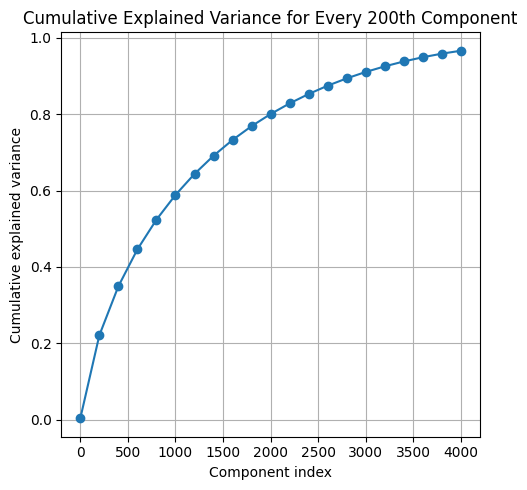

In [10]:
plot_variance(pca.explained_variance_ratio_)

ukupna opisana varijansa treba da bude > 90%, moguce je pomocu pca smanjiti dimneziju na 3000. medjutim podaci sigurno imaju dosta sumova itd pa moze i na 2000 sa 80%

ocekujemo da lsa opisuje otp slicno kao pca

In [11]:
lsa = TruncatedSVD(n_components=2000)
lsa.fit(X)
X_lsa = lsa.transform(X)

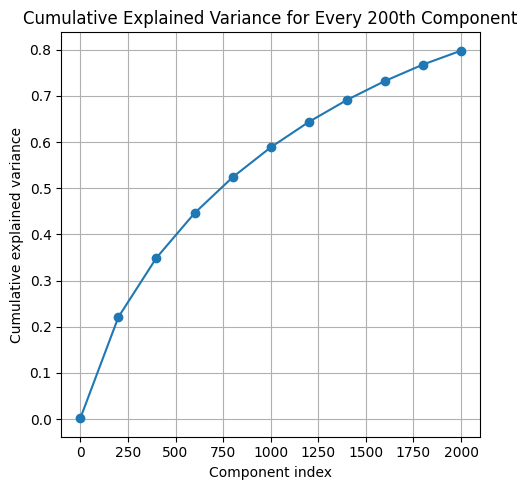

In [12]:
plot_variance(lsa.explained_variance_ratio_)

nadalje koristimo x_lsa, zadovoljni smo sa 80%



# Odabir broja klastera na osnovu analize

In [13]:
cosine_sim = cosine_similarity(X_lsa)
cosine_dist = 1 - cosine_sim

In [14]:
complete_cos = linkage(cosine_dist, method='complete')
ward_cos = linkage(cosine_dist, method='ward')
average_cos = linkage(cosine_dist, method='average')

In [15]:
complete_X = linkage(X_lsa, method='complete')
ward_X = linkage(X_lsa, method='ward')
average_X = linkage(X_lsa, method='average')

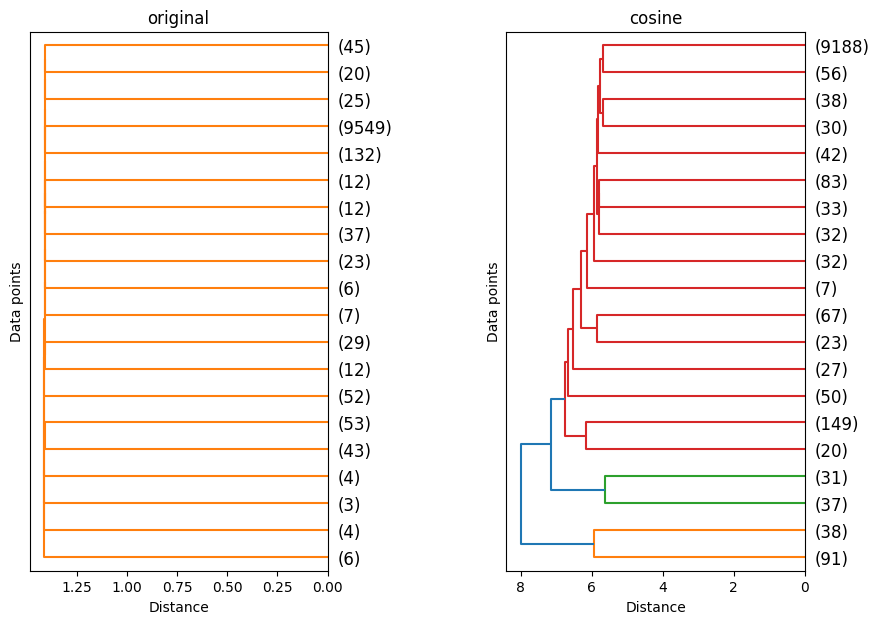

In [16]:
plot_dendograms(complete_X, complete_cos, 6, 7)

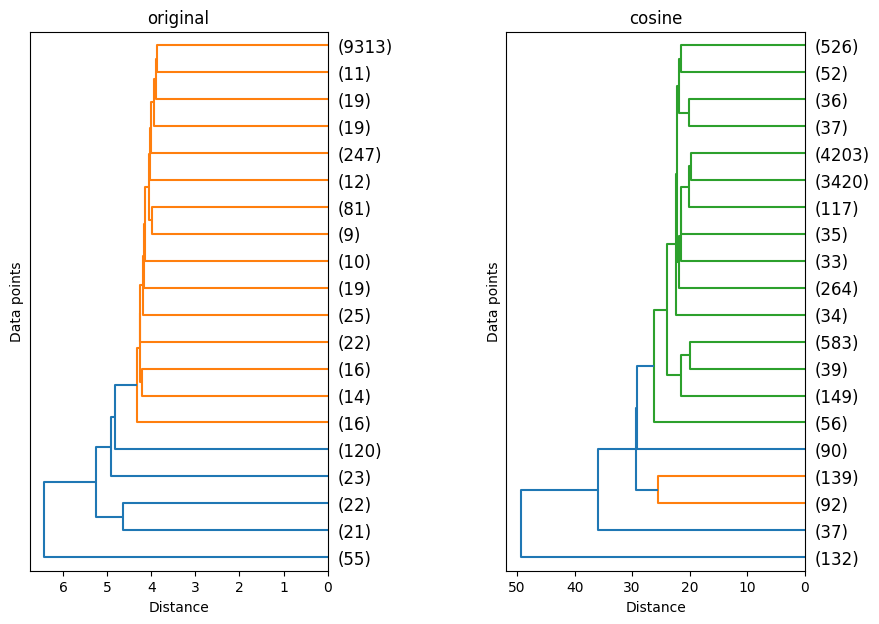

In [28]:
plot_dendograms(ward_X, ward_cos, 4.5, 27)

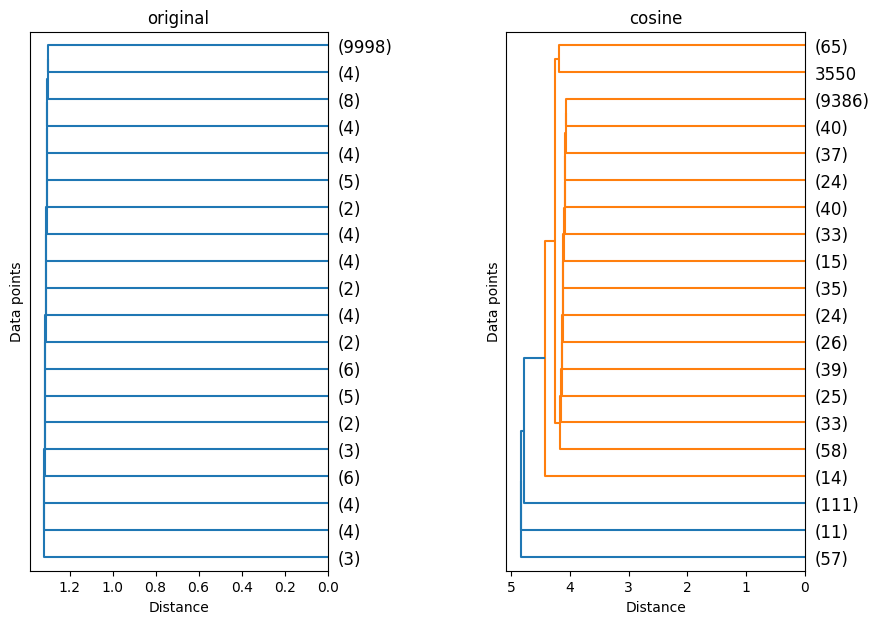

In [18]:
plot_dendograms(average_X, average_cos, 1, 4.5)

ovde je ward za kosinusne jedini koji je nesto i uradio mada i to je relativno lose jer jedan klaster ima ~95% podataka a ostalih 2,3 su bas sitni. ostali sve prakticno grupisu u jedan klaster. ovako nesto se ocekuje od hijerarhijskog klasterovanja na tekstu, ne moze da pohvata toliko kompleksan oblik podataka. cisto ilustrativno prikazujemo klasterovanje za n=2,3,4

In [19]:
lsa = TruncatedSVD(n_components=2)
lsa_matrix = lsa.fit_transform(cosine_dist)

In [20]:
lsa = TruncatedSVD(n_components=3)
lsa_matrix_3 = lsa.fit_transform(cosine_dist)

In [21]:
def plot_cluster(n_clusters, X, lsa_2d, lsa_3d, best_score, best_model):
  clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit(X)
  labels = clustering.labels_
  curr_silhouette = silhouette_score(cosine_dist, labels)
  if (curr_silhouette > best_score):
    best_score = curr_silhouette
    best_model = clustering
  print(curr_silhouette)
  plot_lsa(lsa_2d, lsa_3d, labels)

  return best_model, best_score

0.23384467312257823


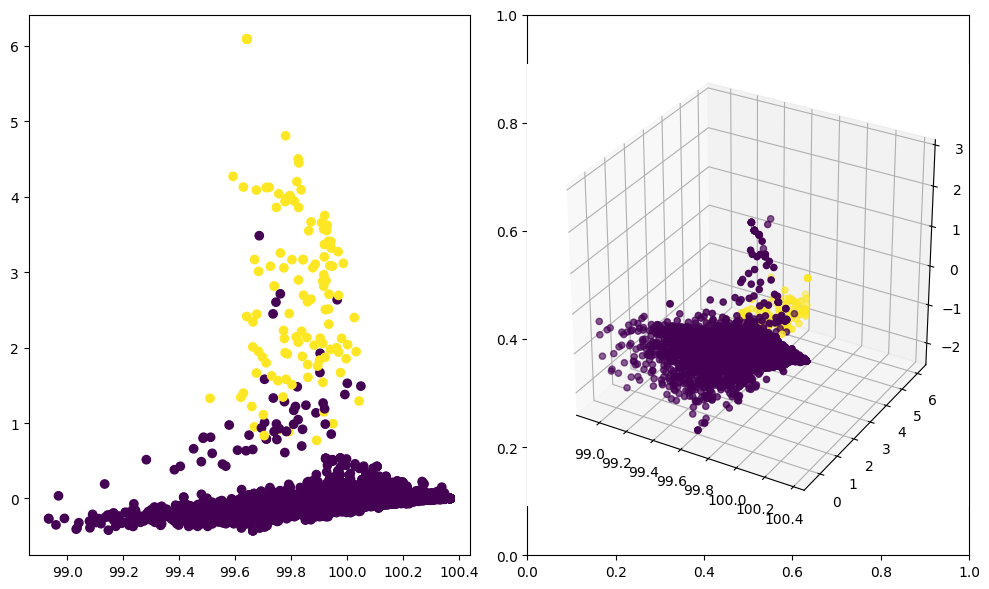

In [22]:
best_model, best_score = plot_cluster(2, cosine_dist, lsa_matrix, lsa_matrix_3, -1, 0)

0.23573741415504804


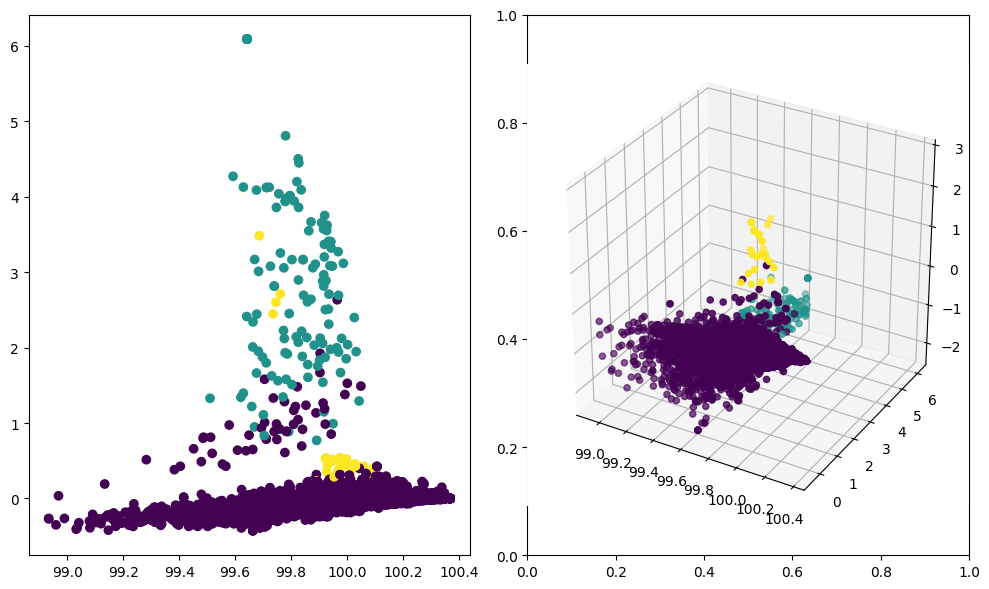

In [23]:
best_model, best_score = plot_cluster(3, cosine_dist, lsa_matrix, lsa_matrix_3, best_score, best_model)

0.10192102786479605


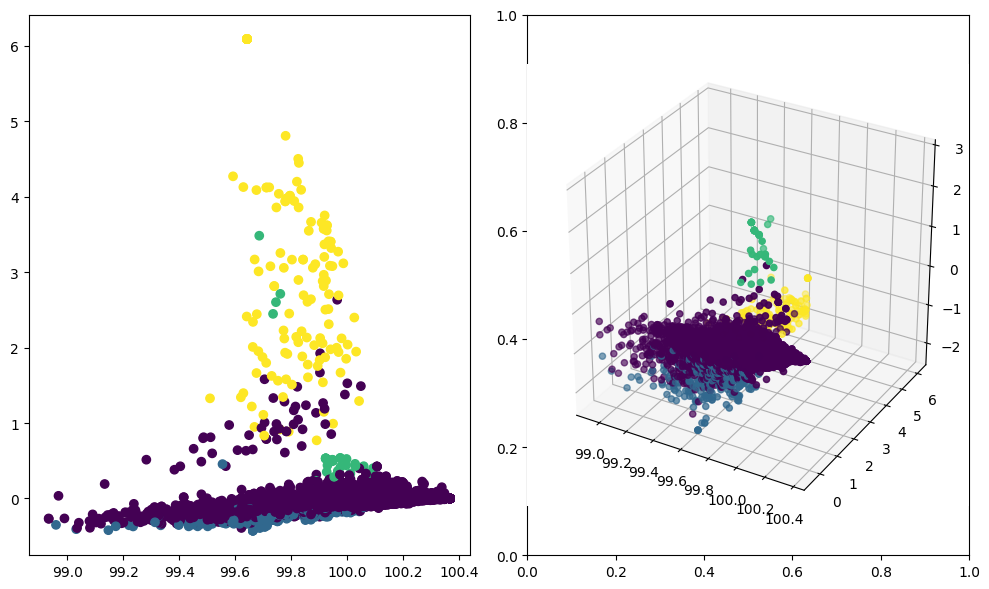

In [24]:
best_model, best_score = plot_cluster(4, cosine_dist, lsa_matrix, lsa_matrix_3, best_score, best_model)

In [26]:
best_model

AgglomerativeClustering(n_clusters=3)

In [27]:
joblib.dump(best_model, 'hierarchical_model.joblib')

['hierarchical_model.joblib']